# 학습목표
- RNN의 개념을 이해하자
- 텍스트마이닝 기초 개념을 이해하자

## 데이터 로드

In [ ]:
# 작업 디렉토리 이동
%cd "./drive/MyDrive/Colab Notebooks/딥러닝 기초 25.07.11 (class 2)"

/content/drive/MyDrive/Colab Notebooks/딥러닝 기초 25.07.11 (class 2)


In [ ]:
import pandas as pd

In [ ]:
naver_df_train = pd.read_csv("./data/ratings_train.txt", delimiter="\t")

In [ ]:
naver_df_train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
naver_df_test = pd.read_csv("./data/ratings_test.txt", delimiter="\t")
naver_df_test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
naver_df_train.shape, naver_df_test.shape

((150000, 3), (50000, 3))

### 결측치 제거 및 문제/답 분리

In [ ]:
# 결측치 제거
naver_df_train.dropna(inplace=True)

In [ ]:
naver_df_test.dropna(inplace=True)

In [ ]:
naver_df_train.shape, naver_df_test.shape

((149995, 3), (49997, 3))

In [ ]:
# 문제와 답 분리
X_train_text = naver_df_train['document']
X_test_text = naver_df_test['document']

print("훈련용 리뷰데이터 갯수 : ", len(X_train_text))
print("평가용 리뷰데이터 갯수 : ", len(X_test_text))

훈련용 리뷰데이터 갯수 :  149995
평가용 리뷰데이터 갯수 :  49997


In [ ]:
y_train = naver_df_train['label']
y_test = naver_df_test['label']

y_train.shape, y_test.shape

((149995,), (49997,))

In [ ]:
X_train_text[0]

'아 더빙.. 진짜 짜증나네요 목소리'

In [ ]:
y_train[0]

np.int64(0)

## 토큰화 및 수치화
- 토큰화 : 문장을 쪼개는 작업
  1. char 단위
  2. 단어단위(띄어쓰기)
  3. n-gram
  4. 형태소 단위
- 수치화 : 토큰을 숫자로 변경하는 작업
  1. 빈도기반
    - 랭킹기반 라벨인코딩
    - BOW, Tf-idf
  2. 학습기반
    - word embedding(단어임베딩)
    - document embedding(문서임베딩)

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
vectorizer = TextVectorization(
    output_mode = 'int', # 빈도를 기반으로 랭킹화(수치화 방법)
    standardize = 'lower_and_strip_punctuation', # 소문자로 변경 및 문장부호 제거
    max_tokens = 5000, # 사용할 단어의 최대 수(빈도기반)
    output_sequence_length = 15 # 문장의 최대 길이 설정
)

In [ ]:
# 토큰화 및 수치화 진행
vectorizer.adapt(X_train_text)
X_train = vectorizer(X_train_text)
X_test = vectorizer(X_test_text)

In [ ]:
X_train[0]

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([  37,  914,    5,    1, 1077,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])>

In [ ]:
X_train.shape, X_test.shape

(TensorShape([149995, 15]), TensorShape([49997, 15]))

## SimpleRNN 모델링
- tanh(y=wh+wx+b)

In [ ]:
from tensorflow.keras.models import Sequential # 모델의 뼈대를 구성
from tensorflow.keras.layers import InputLayer, Dense, SimpleRNN # 바닐라 RNN 구현 도구
from tensorflow.keras.callbacks import EarlyStopping # 조기학습중단

In [ ]:
# 모델설계
simple_rnn = Sequential() # 뼈대 생성
# 입력층
simple_rnn.add(InputLayer(shape=(15, 1))) # Time steps(순환횟수), Features(특성수)
# 중간층
simple_rnn.add(SimpleRNN(units=1)) # 순환신경망 레이어 추가(활성화함수 기본 값 tanh)
# 출력층
simple_rnn.add(Dense(1, activation='sigmoid')) # 출력값이 문장의 긍/부정 확률

In [ ]:
# 학습방법 설정
simple_rnn.compile(loss="binary_crossentropy",
                   optimizer="Adam",
                   metrics=['accuracy'])

In [ ]:
# 모델학습
early = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1) # 조기학습중단
simple_h = simple_rnn.fit(X_train,
                          y_train,
                          validation_split=0.2,
                          epochs=100,
                          callbacks=[early])

Epoch 1/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.5007 - loss: 0.6972 - val_accuracy: 0.5032 - val_loss: 0.6932
Epoch 2/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.5027 - val_loss: 0.6931
Epoch 3/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5022 - val_loss: 0.6931
Epoch 4/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.4977 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932
Epoch 5/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.5013 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 6/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.5010 - loss: 0.6931 - val_accuracy: 0.5025 - val_loss: 0.6932
Epoch 6: early stopping


In [ ]:
# 시각화
import matplotlib.pyplot as plt

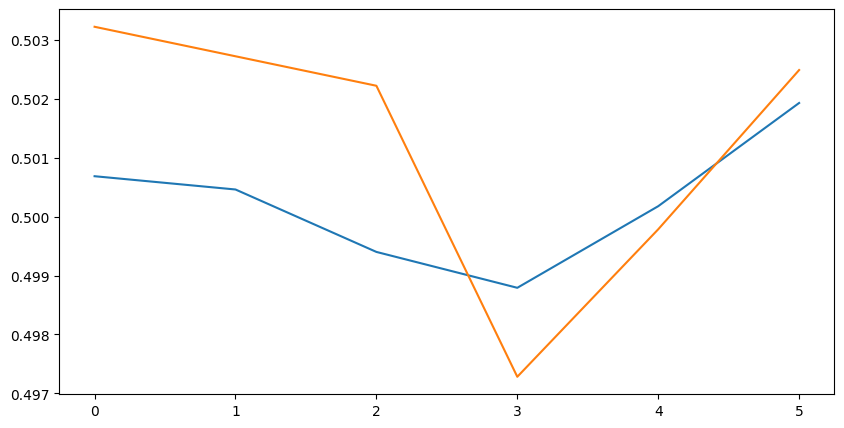

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(simple_h.history['accuracy'], label='train_accuracy')
plt.plot(simple_h.history['val_accuracy'], label='valid_accuracy')
plt.show()

## LSTM 모델링
- SimpleRNN의 경우 시퀀스의 길이가 길면 학습이 안되는 경우가 많다.
- RNN의 순환연산이 많아지면 기울기 소실현상이 빨라지기 때문
- 초반에 입력된 단어의 중요성이 후반까지 전달되지 않는 것
- 단어의 중요성에 따라 가중치를 조절해 장/단기 기억을 관리하는 LSTM이 등장

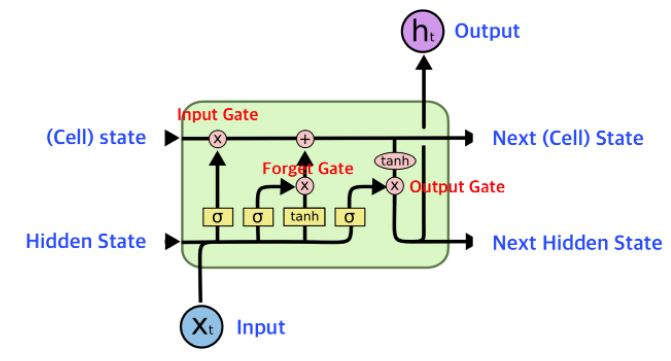

In [ ]:
from tensorflow.keras.layers import LSTM # 장단기 기억 메모리 RNN

In [ ]:
# 모델설계
lstm_rnn = Sequential() # 뼈대 생성
# 입력층
lstm_rnn.add(InputLayer(shape=(15, 1))) # Time steps(순환횟수), Features(특성수)
# 중간층
# lstm_rnn.add(LSTM(units=1)) # 순환신경망 레이어 추가(활성화함수 기본 값 tanh)
lstm_rnn.add(LSTM(units=1, return_sequence = True))
lstm_rnn.add(LSTM(units=1, return_sequence = True))
lstm_rnn.add(LSTM(units=1, return_sequence = True))
lstm_rnn.add(LSTM(units=1, return_sequence = True))
lstm_rnn.add(LSTM(units=1, return_sequence = True))
lstm_rnn.add(LSTM(units=1, return_sequence = True))
lstm_rnn.add(LSTM(units=1))
# 출력층
lstm_rnn.add(Dense(1, activation='sigmoid')) # 출력값이 문장의 긍/부정 확률

In [ ]:
# 학습방법 설정
lstm_rnn.compile(loss="binary_crossentropy",
                   optimizer="Adam",
                   metrics=['accuracy'])

In [ ]:
# 모델학습
early = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1) # 조기학습중단
lstm_h = lstm_rnn.fit(X_train,
                          y_train,
                          validation_split=0.2,
                          epochs=100,
                          callbacks=[early])

Epoch 1/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.5031 - loss: 0.6931 - val_accuracy: 0.5027 - val_loss: 0.6929
Epoch 2/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.5041 - loss: 0.6928 - val_accuracy: 0.5125 - val_loss: 0.6923
Epoch 3/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.5176 - loss: 0.6921 - val_accuracy: 0.5156 - val_loss: 0.6923
Epoch 4/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.5195 - loss: 0.6919 - val_accuracy: 0.5165 - val_loss: 0.6922
Epoch 5/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.5191 - loss: 0.6919 - val_accuracy: 0.5184 - val_loss: 0.6923
Epoch 6/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.5204 - loss: 0.6920 - val_accuracy: 0.5197 - val_loss: 0.6921
Epoch 7/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.5232 - loss: 0.6914 - val_accuracy: 0.5177 - val_loss: 0.6920
Epoch 8/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5199 -

## 임베딩
- 자연처리 모델의 발전에는 크게 2개 포인트가 있다
- 학습을 잘 하도록 알고리즘을 개선하는 방향, 입력 단어의 수치화를 정교하게 하는 방향
- 워드임베딩 : 학습을 통해서 단어의 의미를 정교한 숫자집합으로 만들어내는 기술

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
# 모델설계
embedding_model = Sequential() # 모델뼈대 생성
# 임베딩 레이어 추가
embedding_model.add(Embedding(5000,80)) # 사용되는 단어 수, 각 단어를 표현할 특성 수
# 중간층
embedding_model.add(LSTM(units=256)) # 장단기 기억 RNN 추가
# 출력층
embedding_model.add(Dense(units=1, activation="sigmoid"))

In [ ]:
# 학습방법 설정
embedding_model.compile(loss="binary_crossentropy",
                   optimizer="Adam",
                   metrics=['accuracy'])

In [ ]:
# 모델학습
early = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1) # 조기학습중단
embedding_h = embedding_model.fit(X_train,
                          y_train,
                          validation_split=0.2,
                          epochs=100,
                          callbacks=[early])

Epoch 1/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.7110 - loss: 0.5318 - val_accuracy: 0.7626 - val_loss: 0.4592
Epoch 2/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.7792 - loss: 0.4217 - val_accuracy: 0.7740 - val_loss: 0.4376
Epoch 3/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.7873 - loss: 0.4020 - val_accuracy: 0.7766 - val_loss: 0.4437
Epoch 4/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.7996 - loss: 0.3830 - val_accuracy: 0.7738 - val_loss: 0.4490
Epoch 5/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.8089 - loss: 0.3641 - val_accuracy: 0.7712 - val_loss: 0.4653
Epoch 6/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.8179 - loss: 0.3433 - val_accuracy: 0.7711 - val_loss: 0.4918
Epoch 7/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.8292 - loss: 0.3203 - val_accuracy: 0.7623 - val_loss: 0.5153
Epoch 8/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8418 -

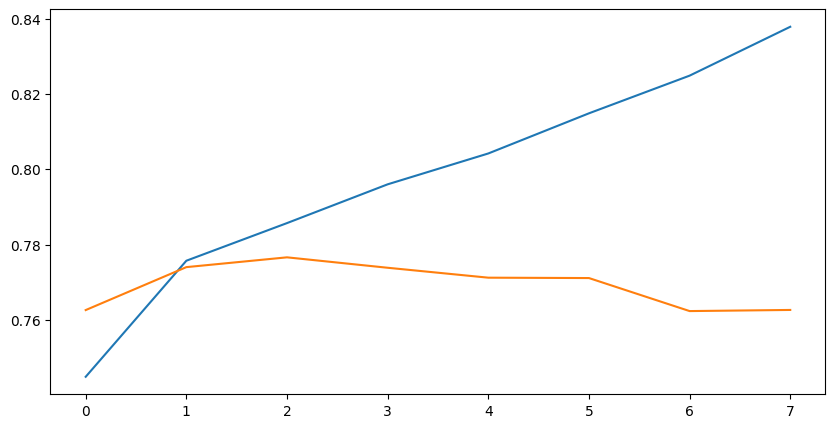

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(embedding_h.history['accuracy'], label='train_accuracy')
plt.plot(embedding_h.history['val_accuracy'], label='valid_accuracy')
plt.show()

### 임베딩 벡터 확인하기

In [ ]:
embedding_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 80)         │       400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       345,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,236,037 (8.53 MB)

 Trainable params: 745,345 (2.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,490,692 (5.69 MB)

In [ ]:
layer = embedding_model.get_layer("embedding")
layer

<Embedding name=embedding, built=True>

In [ ]:
w = layer.get_weights()
w[0].shape # 임베딩 벡터

(5000, 80)

In [ ]:
w[0][0] # 1번째 단어 확인

array([-8.13978434e-01, -9.53817964e-02, -1.22985221e-01, -5.70986941e-02,
       -1.47947378e-03, -4.54442762e-02, -8.38680789e-02,  3.34249772e-02,
        5.56215607e-02, -4.04897124e-01, -9.26038716e-03,  1.10359214e-01,
       -3.44228297e-02,  3.83328050e-02,  2.43230909e-01,  6.40359297e-02,
       -7.28734881e-02,  1.03102393e-01, -1.80130024e-02, -3.60087045e-02,
       -6.51256228e-03,  4.96744290e-02, -6.84691872e-03,  1.59894601e-01,
        6.54276758e-02,  8.26585174e-01, -2.87524778e-02,  9.06078070e-02,
       -2.23293558e-01, -2.37254165e-02, -9.68495384e-02, -1.19084422e-03,
       -1.40756564e-02,  7.70154074e-02,  4.06178720e-02, -1.88747540e-01,
        1.77698720e+00, -3.27045172e-01, -1.00682862e-01, -1.38950229e-01,
       -2.51955986e-02,  1.81182791e-02, -8.46821368e-02,  1.22495547e-01,
        5.69514558e-02,  5.33425361e-02,  2.73175593e-02, -3.84078436e-02,
        2.82755613e-01,  2.94950381e-02,  1.54377297e-02, -5.20136207e-02,
        1.26246852e-03, -